## Máster en Data Science

### Machine Learning

Contacto: angel.blanco@cunef.edu

# **Explicabilidad del modelo**

En este notebook se verá la etapa de explicabilidad del modelo según el método SHAP.

### Librerías

In [19]:
import os
from pathlib import Path

# Cambio del directory al root del proyecto
current_dir = Path.cwd()

if current_dir.name == "notebooks":
    os.chdir(current_dir.parent)


import pandas as pd
# Explicabilidad del modelo
import shap 
shap.initjs()

# Funciones
from src.data import read_test, read_train
from src.models import read_model

# Omitir warnings
import warnings
warnings.filterwarnings('ignore')

### Carga de datos

In [2]:
# Carga de train y test
x_train, y_train = read_train()
x_test, y_test = read_test()

In [3]:
# Modelo en pickle
model = read_model(name="LogisticRegression")

In [17]:
# Predicción
y_pred = model.predict(x_test)

Muchos algoritmos de ML son difíciles de explicar e interpretar, pero debe intentarse entender el por qué de las decisiones que toman, no sólo porque es éticamente correcto saber que el algoritmo no es discriminatorio, sino también porque hay reguladores que exigen que se puedan justificar los comportamientos del algoritmo. Por lo que se debe entender, revisar e interpretar los algoritmos que se implementen para tomar decisiones.

Los algoritmos de este estilo simplemente nos dan una probabilidad de clasificación, pero es necesario explorar el motivo por el que se toma esa decisión porque las métricas no son una representación perfecta de la realidad.

Veamos entonces el modelo SHAP.

### Modelo SHAP

In [4]:
%%time

# Construcción de modelo SHAP
explainer = shap.LinearExplainer(model, x_train, seed=1234)

# Cálculo de los valores SHAP
shap_values = explainer(x_test)

CPU times: user 2.17 s, sys: 124 ms, total: 2.29 s
Wall time: 2.3 s


### Explicabilidad local

El gráfico de explicabilidad local representa, para un registro en concreto, cuáles han sido las variables que más han afectado positivamente y negativamente a que el modelo de el valor que da para ese individuo. Es interesante para analizar casos por ejemplo de un género o de un rango de edad para ver si el modelo está sesgado y les discrimina o no.

Como es interesante ver el caso concreto de un falso negativo y un falso positivo, primero filtro esa información.

In [23]:
# Dataframe con test frente a pred
classifications = pd.DataFrame(
    {
        "y_true": y_test["fraud_bool"],
        "y_pred": y_pred
    }
)

classifications

,y_true,y_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
199995,0,0
199996,0,0
199997,0,0
199998,0,0


In [56]:
# Filtro de índices de falsos negativos y positivos
false_positive_indices = classifications.query("y_true == 0 and y_pred == 1").index
false_negative_indices = classifications.query("y_true == 1 and y_pred == 0").index

print(f"Número de falsos positivos: {len(false_positive_indices):,}")
print(f"Número de falsos negativos: {len(false_negative_indices):,}")

Número de falsos positivos: 8,555
Número de falsos negativos: 1,427


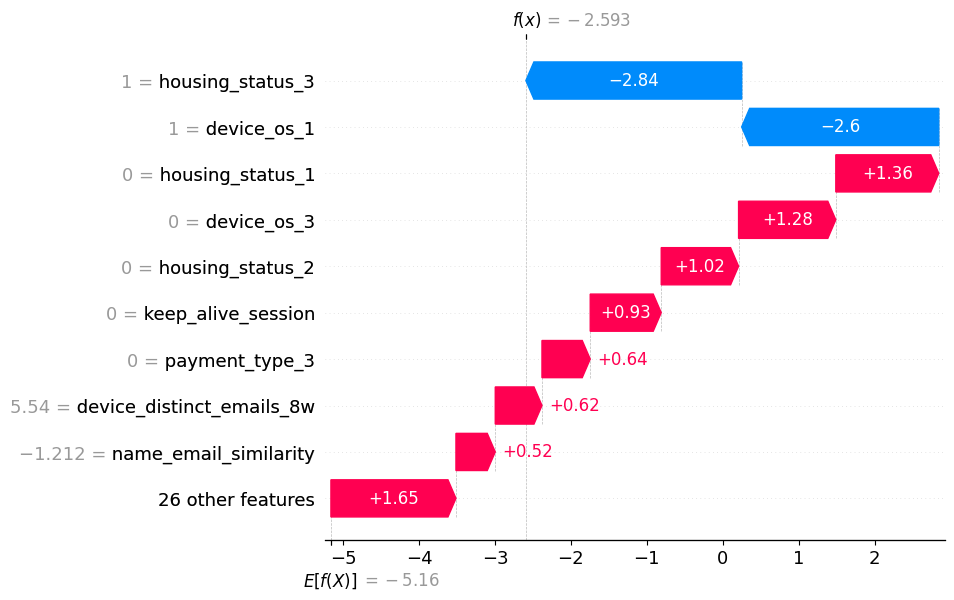

In [58]:
# Gráfico de explicabilidad local para el primer individuo que presenta falso negativo
shap.plots.waterfall(shap_values[false_negative_indices[0]], max_display=10)

Las barras rojas indican un impacto positivo hacia el modelo, mientras qyue las azules lo contrario. El valor de f(x) = -2.593 en la parte superior del gráfico es la puntuación final del modelo después de tener en cuenta todas las contribuciones de las características.

Puede verse que las tres variables que más afectan a la decisión de este falso negativo han sido housing_status_3, device_os_1 y housing_status_1. Habría que ver en media cuáles afectaron más en los falsos negativos, porque podría significar que estas variables confunden al modelo.

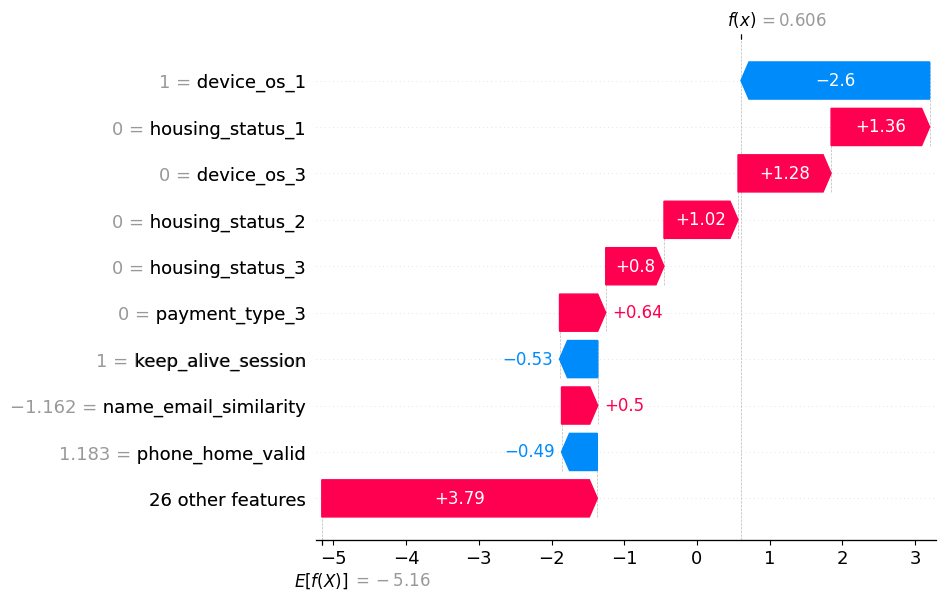

In [59]:
# Gráfico de explicabilidad local para el primer individuo que presenta falso positivo
shap.plots.waterfall(shap_values[false_positive_indices[0]], max_display=10)

De nuevo, vemos como housing_status_3 y device_os_1 están en las variables que más afectaron al modelo en este caso de falso positivo, lo que podría ser indicador de lo mencionado en el gráfico anterior.

Es interesante ver como alguna de las variables afecta positiva o negativamente al valor SHAP según el valor que haya tomado para el individuo. Esto se observa contrastando ambos gráficos, pero también con el gráfico de explicabilidad general.

### Explicabilidad general

El summary plot resume la influencia en el modelo de cada una de las variables, para cualquier observación. Este gráfico agrega los valores shap para todas las variables y cada individuo y representa gráficamente su función de densidad. 

Sirve para ver como la influencia de las variables no es de la misma magnitud en ambos sentidos, puesto que muchas de las funciones de densidad presentan una mezcla de color, lo que indica que en un sentido influye con más fuerza que en el otro, pero también puede ser útil para localizar valores outliers. 

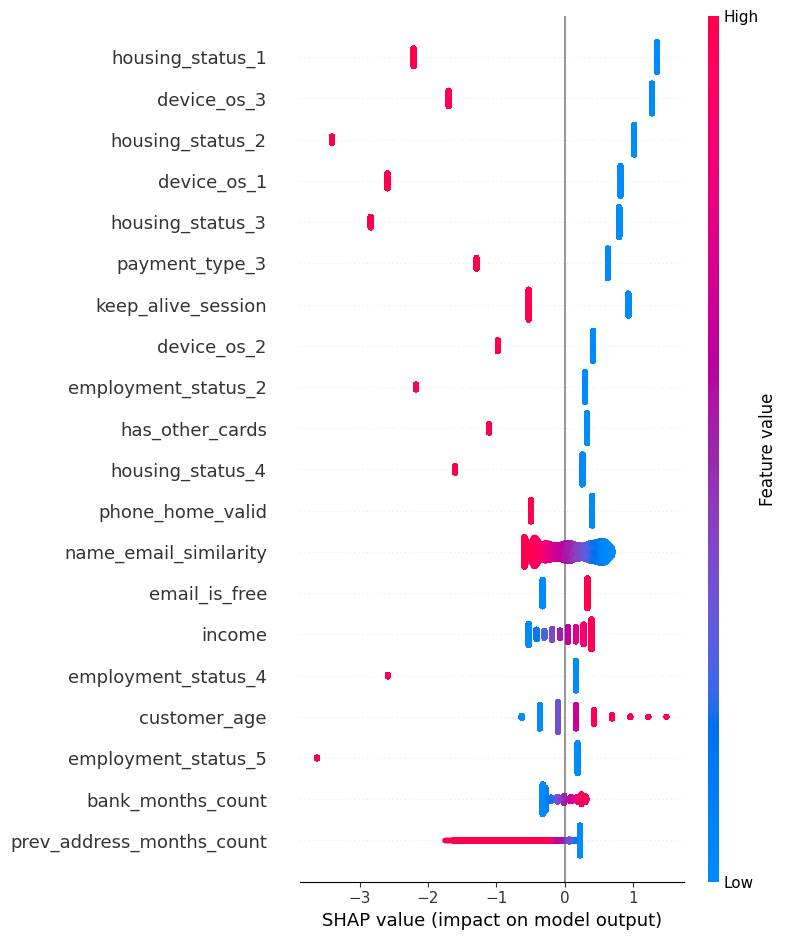

CPU times: user 12.4 s, sys: 3.38 s, total: 15.8 s
Wall time: 11.3 s


In [8]:
%%time

shap.summary_plot(shap_values, x_test)

Del gráfico destaca que:

- Cuando el cliente ya tiene otro crédito con el mismo banco (has other cards), es muy posible que el modelo lo clasifique como baja probabilidad de fraude.

- En la variable name_email_similarity, para valores altos de similitud se ve que influyen negativamente en que el modelo de una alta probabilidad de fraude, es decir, a mayor similitud, menos probabilidad. 

- La edad afecta positivamente al modelo en valores altos de la variable, es más probable el fraude.

- Para valores altos de ingresos (income), es más probable que salga alta probabilidad de fraude.

- Para casos en los que la cuenta del cliente es más antigua, el impacto en el modelo es positivo.

- En los casos en los que el email es de dominio de pago, afectan al modelo de forma positiva.

- Cuando el número de emails con la misma fecha de nacimiento asociada a la cuenta en las últimas 4 semanas es alto, el efecto en el modelo es negativo.

- Si el número de teléfono fijo aportado por el aplicante es válido, esto tiene un efecto positivo en el modelo.

Estos son unos de los ejemplos de como afecta cada variable y valor al modelo a la hora de clasificar.